In [1]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from collections import Counter

In [2]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [3]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [4]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [71]:
n = 16

j = read_j_coef('L4/sample3/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample3/configurations_T2.dat', n)
spins = spins[::4]# en el cas de n=16
hams = np.array([round(hamiltonian(s, h, j), 8) for s in spins])

In [77]:
n = 64

j = read_j_coef('L8/sample3/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L8/sample3/configurations_T2.dat', n)
#spins = spins[::4]# en el cas de n=16
hams = np.array([round(hamiltonian(s, h, j), 8) for s in spins])

In [47]:
print(hams[:5])

[-10.1500002 -13.376667  -17.2033334  -1.323334  -27.3366674]


1.000000000000167



3.129999999999998
1299760793.6737595


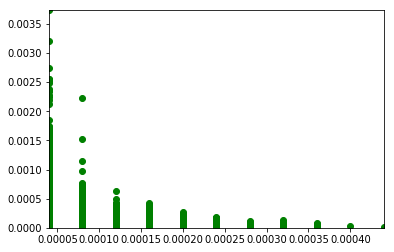

0.9999476304197168


In [78]:
from sklearn.linear_model import LinearRegression
counts = Counter(hams)
prob = {}
for k, v in dict(counts).items():
    prob[k] = float(v)/25000
print(sum(prob.values()))
r = float('-inf')
dif = 0.
results_x6 = []
results_y6 = []
for t in tqdm_notebook(np.arange(0.07, 10, 0.01)):
    sum_denom = 0
    for k, v in prob.items():
        sum_denom += np.exp(-k/t)
    probab = {}
    for k, v in prob.items():
        probab[k] = np.exp(-k/t)/sum_denom
    fit_x = np.array(list(prob.values())).astype(float)
    fit_y = np.array(list(probab.values())).astype(float)
    model = LinearRegression().fit(fit_x.reshape((-1,1)), fit_y)
    r_sq = model.score(fit_x.reshape((-1,1)), fit_y)
    
    results_x6.append(t)
    results_y6.append(r_sq)
    if r_sq > r:
        r = r_sq
        dif = t
print(dif)

sum_denom = 0
for k, v in prob.items():
    sum_denom += np.exp(-k/dif)
print(sum_denom)
probab = {}
for k, v in prob.items():
    probab[k] = np.exp(-k/dif)/sum_denom

    

plt.scatter(prob.values(), probab.values(), c='green')
plt.xlim(min(prob.values()), max(prob.values()))
plt.ylim(min(probab.values()), max(probab.values()))
plt.show()

#plt.plot(np.array(results_x), np.array(results_y), c='red')
#plt.ylim(min(np.array(results_y)), max(np.array(results_y)))
#plt.show()
print(max(np.array(results_y)))


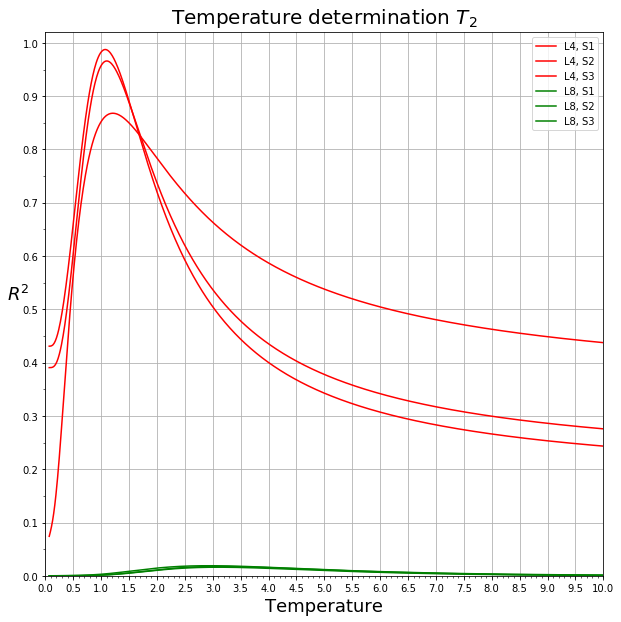

In [79]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.title(r'Temperature determination $T_2$', fontsize=20, y=1.005)
plt.xlabel(r'Temperature', rotation=0, fontsize=18)
plt.ylabel(r'$R^2$', rotation=0, fontsize=18)
plt.plot(np.array(results_x1), np.array(results_y1), c='red', label='L4, S1')
plt.plot(np.array(results_x2), np.array(results_y2), c='red', label='L4, S2')
plt.plot(np.array(results_x3), np.array(results_y3), c='red', label='L4, S3')
plt.plot(np.array(results_x4), np.array(results_y4), c='green', label='L8, S1')
plt.plot(np.array(results_x5), np.array(results_y5), c='green', label='L8, S2')
plt.plot(np.array(results_x6), np.array(results_y6), c='green', label='L8, S3')
plt.ylim(0, 1.02)
plt.xlim(0, 10)
#plt.ylim(min(np.array(results_y)), max(np.array(results_y)))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid()
plt.legend(loc=1)
plt.savefig('Temperature_T2.png', bbox_inches = 'tight')
plt.show()

In [ ]:
values, base = np.histogram(hams, bins=1000000)
cumulative = np.cumsum(values, dtype='float')
x_data = base[:-1]
y_data = cumulative/25000
y_reg = np.log(1-y_data)
plt.plot(x_data, values, c='green')
plt.show()
plt.plot(x_data, y_data, c='green')
plt.show()
plt.plot(x_data, y_reg, c='green')
plt.show()

In [ ]:
a = np.array([0,0,1,0,1,1,0,1,1,0,1,0,1,0,1,1], dtype='int')
b = np.array([1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0], dtype='int')
def inverse(a):
    return np.abs(a-1)
def changes(a, b):
    return min(np.sum(np.abs(a-b)), np.sum(np.abs(a-inverse(b))))
print(a)
print(inverse(a))
print(changes(a, b))

In [ ]:
max_freq = np.flip(np.array([0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0], dtype='int'))
print(max_freq)

In [ ]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [ ]:
print(ncr(16,2))

In [ ]:

hist_s = (sample+1)/2
new = []
new1 = []
for i in hist_s:
    sub = 0
    sub2 = 0
    for k in range(len(i)):
        sub += i[k] * 2**k
        sub2 += (1-i[k]) * 2**k
    new1.append(min(sub, sub2))
    new.append(changes(max_freq, i))
print(Counter(new1).most_common(5))
counts = dict(Counter(new))

for k, v in counts.items():
    counts[k] = counts[k]/ncr(16, int(k))
print(counts)
print(Counter(new).most_common(9))

plt.figure(figsize = (16, 10))
ax = plt.axes()
plt.title('T3')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.bar(counts.keys(), counts.values())
#plt.xlim(0, 34000)
#plt.ylim(0, 9000)
#plt.xticks(np.arange(-0.07, 0.071, 0.01))
plt.grid()
#plt.savefig('t3.png')
plt.show()